### <center>Machine Learning Project 1

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
# import proj1_helpers
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from implementations import *
from prettytable import PrettyTable

#### Step I: Feature Engineering
##### 1.1 Study the features
Our first step is to thoroughly study the features, including missing values, correlations between features and labels, etc.

##### 1.1.1 missing values

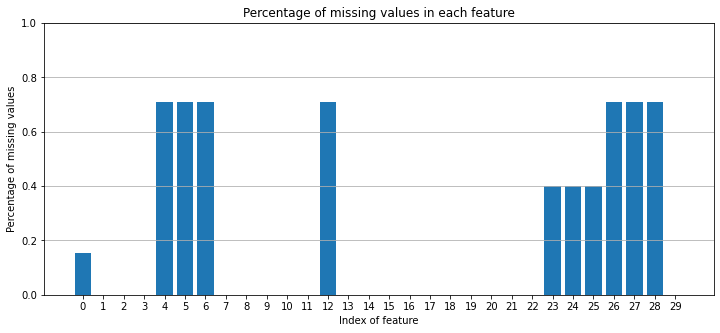

In [5]:
detect_missing_values(tX)

From this figure, we can see that for some features (feature 4, 5, 6, 12, 26, 27, 28), there is a significant number of missing values (over 70%). Our immediate thought is that they should be deleted for their lack of information, but we will later test whether keeping these features would lead to higher validation accuracy first.

Besides, we will study whether the missing values itself is related to the labels. We study this by comparing the overall ratio for $\frac{positive\ samples}{negative\ samples}$, and the ratio for the data with missing values in a specific feature.

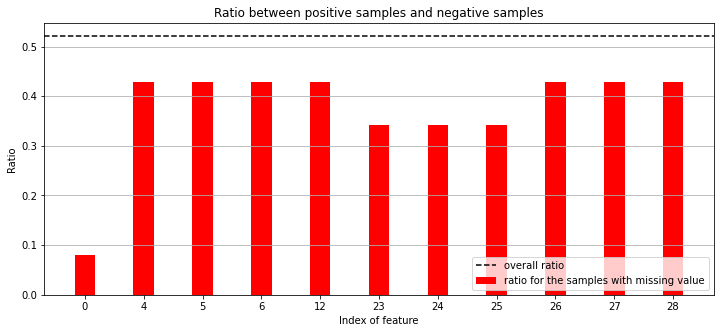

In [6]:
plot_missing_value_class_ratio(tX, y)

We see that, the overall $\frac{positive\ samples}{negative\ samples}$ ratio is just above 0.5. While for all the features with missing values, their ratios are below the overall ratio. For the 0th, 23rd, 24th, 25th features, it has a extremely low ratio, meaning that for these features whether containing missing values gives us much information about the labels.

We create two new indicator features of missing values in 'DER\_mass\_MMC', 'PRI\_jet\_leading\_pt', 'PRI\_jet\_leading\_eta', and 'PRI\_jet\_leading\_phi' (corresponding feature indexes: 0, 23, 24, 25). Later we will see that using the missing value indicators will improve our prediction accuracy.

In [7]:
indicator_feature_1 = np.int32(tX[:,0] == -999)
indicator_feature_2 =  np.int32(tX[:,23] == -999) + np.int32(tX[:,24] == -999) + np.int32(tX[:,25] == -999)

##### 1.1.2 feature correlations

Now we study the correlations between each feature and the class label. The goal is to identify whether certain features are more important than others (more correlated to class label).

* correlation coefficients between features and label

Before study the feature correlations, we first replace the missing values by the median values, so that the outliers won't damage the correlations. We choose to replace with median instead of mean, because median values are more robust to outliers.

In [8]:
tX_clean = replace_missing_values(tX)

First, we calculate the correlation coeffients

In [9]:
# calculate the correlation coefficients between features and label
corr_coefs = []
for i in range(tX_clean.shape[1]):
    corr_coefs.append((i, round(np.corrcoef(tX_clean[:, i], y)[0,1], 4)))

# sort by descending order of their absolute values
corr_coefs = sorted(corr_coefs, key=lambda x: abs(x[1]), reverse=True)

corr_coefs

[(1, -0.3514),
 (11, 0.2718),
 (13, 0.2352),
 (5, 0.2278),
 (4, 0.2253),
 (6, -0.2138),
 (10, -0.1954),
 (3, 0.1925),
 (23, 0.1647),
 (0, 0.1605),
 (9, 0.1532),
 (21, 0.1355),
 (29, 0.1343),
 (22, 0.1335),
 (26, 0.1099),
 (28, -0.0852),
 (27, -0.076),
 (24, -0.0721),
 (25, -0.072),
 (12, -0.0601),
 (16, -0.0319),
 (19, 0.0225),
 (8, -0.0153),
 (2, -0.0141),
 (7, 0.0122),
 (20, 0.0075),
 (15, -0.0044),
 (18, 0.0041),
 (17, 0.0015),
 (14, -0.0009)]

From the results we can see that, features with index (1, 11, 13) are the most correlated features with labels, while features with index (14, 17, 18) are the least correlated features.

Besides, we also plot the distributions of positive and negative samples for each feature.   
From the distributions we can observe the feature's correlation to the class label by finding if the feature distributions show significant difference for opposite labels

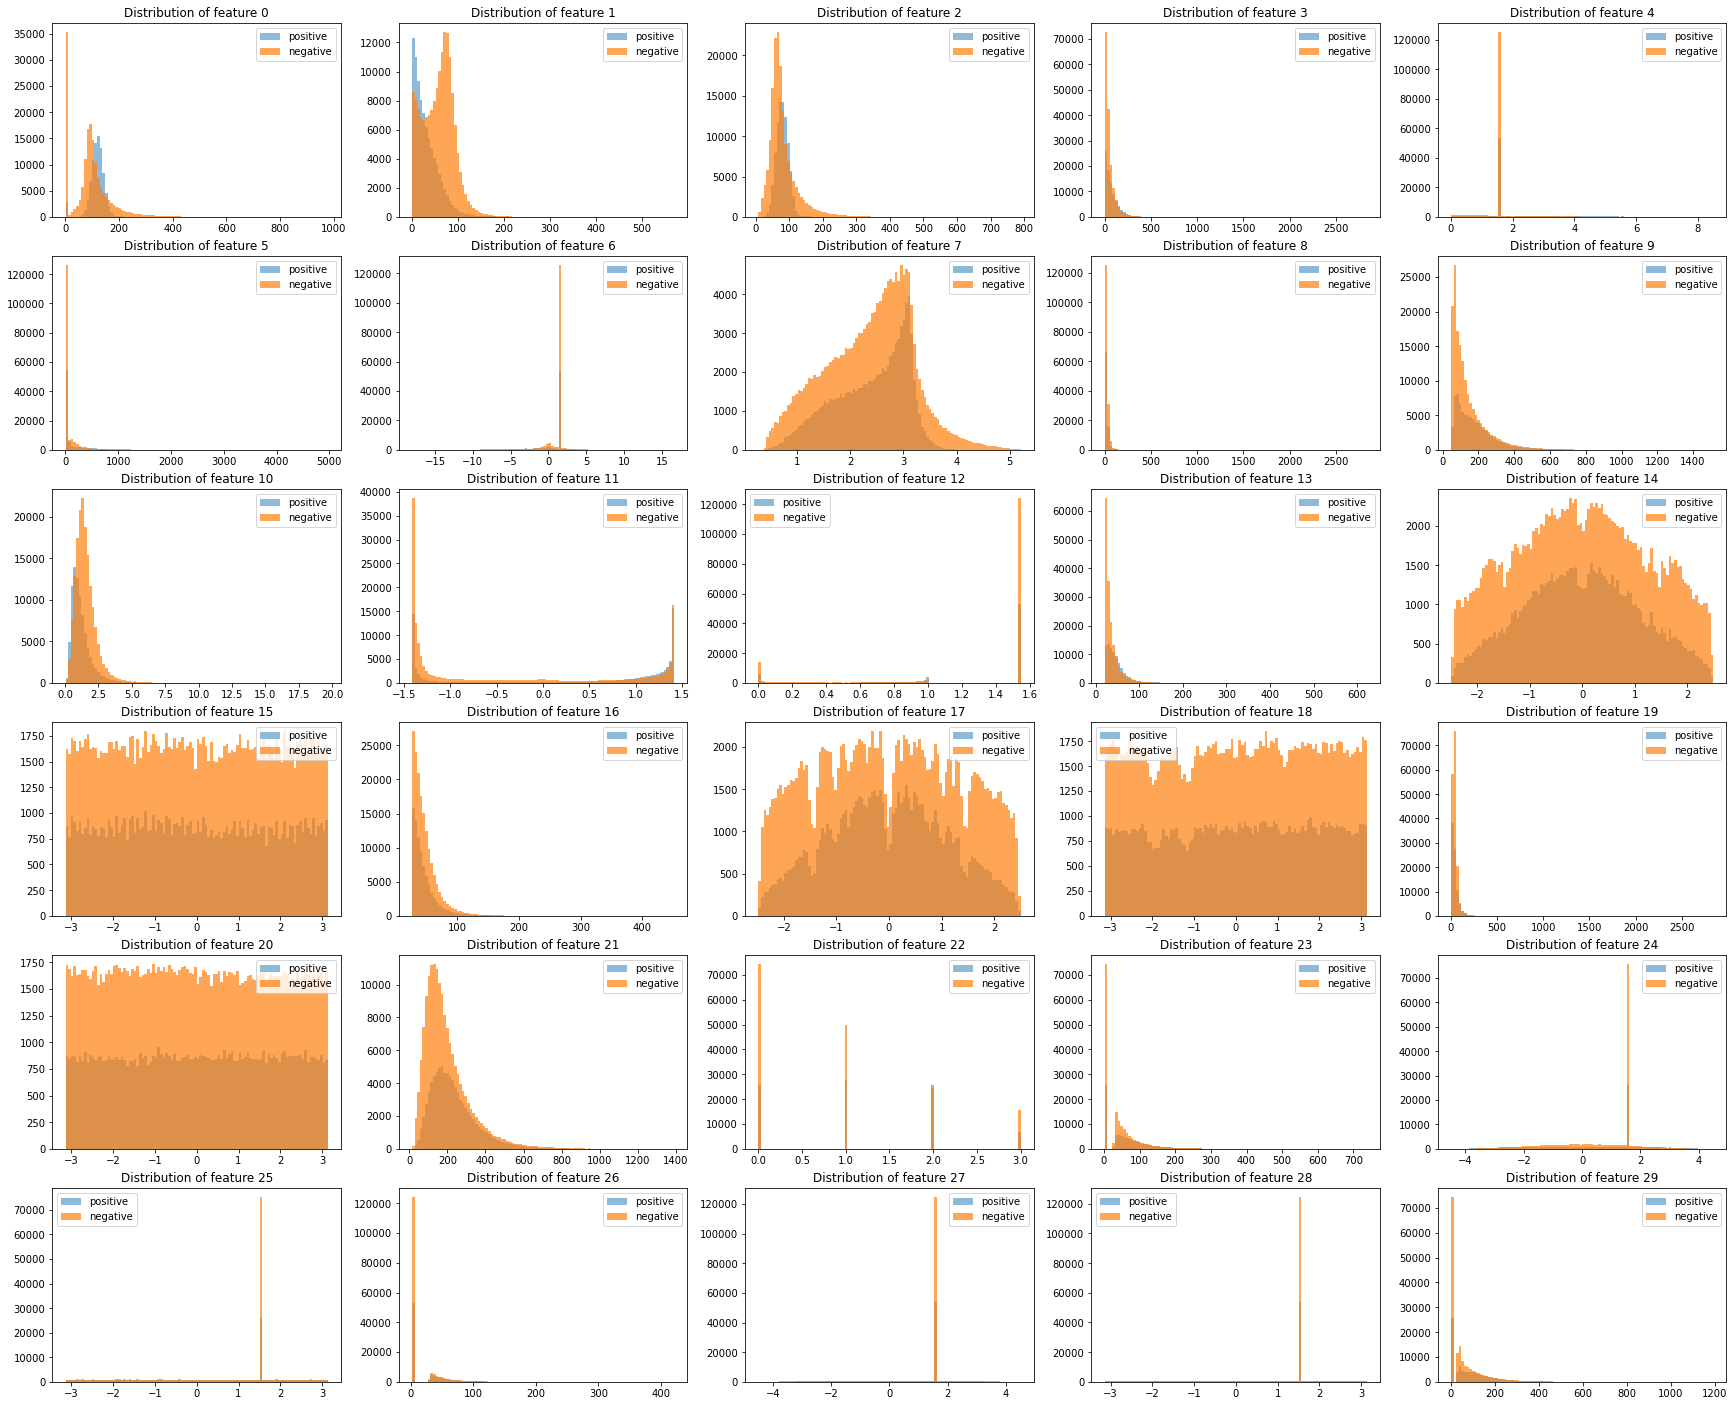

In [10]:
plot_distribution(tX_clean, y)

From the figures, we can see that the two distributions are most obviously seperated in feature 1, which agrees well with our correlation coefficient results. Besides, feature 0 also shows much difference in distributions from opposite classes.

* correlation coefficients between features

Here we calculate the Pearson correlation coeffiecients between features, plot the coefficients in heatmap, and print the 10 most correlated features.

Ten most correlated features:

feature 29 and 9, corr_coefficient: 0.9656
feature 29 and 23, corr_coefficient: 0.9252
feature 23 and 9, corr_coefficient: 0.9139
feature 21 and 9, corr_coefficient: 0.9045
feature 29 and 21, corr_coefficient: 0.8844
feature 23 and 3, corr_coefficient: 0.8747
feature 6 and 4, corr_coefficient: 0.8611
feature 29 and 26, corr_coefficient: 0.8543
feature 23 and 21, corr_coefficient: 0.8331
feature 9 and 3, corr_coefficient: 0.8327


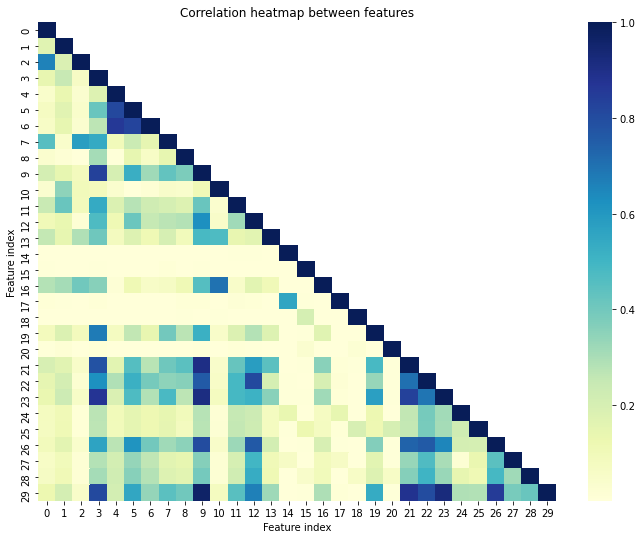

In [11]:
# calculate the absolute vallue of Pearson correlation coefficient between each feature
corr_df = abs(np.corrcoef(tX_clean.T))

# delete the upper-left corner data

corr_df_idx = []
for i in range(corr_df.shape[0]):
    for j in range(0, i):
        corr_df_idx.append((i, j, corr_df[i, j]))
corr_df_idx = sorted(corr_df_idx, key = lambda x: x[2], reverse = True)

print('Ten most correlated features:\n')
for i in range(10):
    print('feature {} and {}, corr_coefficient: {:.4}'.format(corr_df_idx[i][0], corr_df_idx[i][1], corr_df_idx[i][2]))

for i in range(corr_df.shape[0]):
    for j in range(i+1, corr_df.shape[1]):
        corr_df[i][j] = None
        
# plot the correlation lower triangle heatmap 
plt.figure(figsize= (10,8))
hmap = sns.heatmap(corr_df, cmap="YlGnBu")
hmap.figure.savefig("Correlation_Heatmap_Lower_Triangle.png", format='png', dpi=150)
plt.title('Correlation heatmap between features')
plt.xlabel('Feature index')
plt.ylabel('Feature index')
plt.tight_layout() 

From the results, we can see that feature 9, 21, 23, 29 are much related to each other. Therefore, we can keep just one of these 4 features. Here we choose to keep feature 29 and delete feature 9, 21, 23. Later we will test the effect of deleting these features.

##### 1.1.3 cleaning, normalizing and deleting features

First, we replace the missing values (-999) with the median value of the feature column. We use median instead of mean, because median is more robust to outliers.  
After that, we normalize the data through z-score normalization.

For simplicity, we use least squares to test whether deleting a certain feature would contribute to the validation accuracy.

We will test whether deleting these features would improve our prediction accuracy:
* features with over 70% data missing (feature index: 4, 5, 6, 12, 26, 27, 28).
* features with least correlation to class label (feature index: 14, 17, 18).
* features that are highly correlated to each other (feature index: 9, 21, 23).

In [13]:
x_std, _, _, _ = clean_standarize(tX, replace='median')

del_table = PrettyTable(['deleted for', 'feature index', 'val_accuracy after deletion'])

for (deletion_reason, deleted_columns) in [('no deletion', []), ('too many missing data', [4, 5, 6, 12, 26, 27, 28]), \
                                           ('least correlation with y', [14, 17, 18]), ('highly correlated with each other', [9, 21, 23])]:
    
    # delete the features
    x_std_delete = np.delete(x_std, deleted_columns, axis = 1)
    x_std_delete = np.c_[np.ones((len(x_std), 1)), x_std_delete]
    # split data into train and test set
    x_train, y_train, x_test, y_test = split_data(x_std_delete, y, 0.8, seed=1)
    # train and test data
    (train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
    del_table.add_row([deletion_reason, deleted_columns, test_acc_ridge])

print(del_table)

+-----------------------------------+---------------------------+-----------------------------+
|            deleted for            |       feature index       | val_accuracy after deletion |
+-----------------------------------+---------------------------+-----------------------------+
|            no deletion            |             []            |           0.74454           |
|       too many missing data       | [4, 5, 6, 12, 26, 27, 28] |           0.73446           |
|      least correlation with y     |        [14, 17, 18]       |           0.74496           |
| highly correlated with each other |        [9, 21, 23]        |           0.74512           |
+-----------------------------------+---------------------------+-----------------------------+


The result shows that: 
* deleting features with over 70% missing data would damage classification accuracy, suggesting that the feautures still carry some information related to class label.  
* deleting features with least correlation to class label very slightly improves classification accuracy.
* deleting features highly correlated to each other slightly improves classification accuracy.  

We observe that, deleting the forementioned features almost do not change the validation accuracy, some even damage the accuracy, which means deleting them provides very limited help. Besides, even though some features seem unimportant, but their powers or cross product with other features may have a high correlation to the class label (which we will consider later). Therefore, given the two reason, we choose to keep all the features.

##### 1.1.4 one-hot encoding

Feature 22 (jet-num) has 4 distinct values (0, 1, 2, 3), in this case we can transform this column into one-hot encoding. Later we will test whether this transform will benefit classification accuracy.

<center>$ jetnum = 
   \left[ \begin{matrix}
   0 \\ 1 \\ 2 \\ 3 
  \end{matrix}  \right] = \left[ \begin{matrix}
   1 & 0 & 0 & 0  \\
   0 & 1 & 0 & 0  \\
   0 & 0 & 1 & 0  \\
   0 & 0 & 0 & 1  \\
  \end{matrix}  \right]$


In [14]:
one_hot = one_hot_encoder(tX[:, 22])

##### 1.1.5 different data distribution for different jet-num 

While studying the data, we discovered that for the data with different jet-num (feature 22), their distribution can be quiet different.   
The first two PCA components of the data within each jet-num are drawn here:

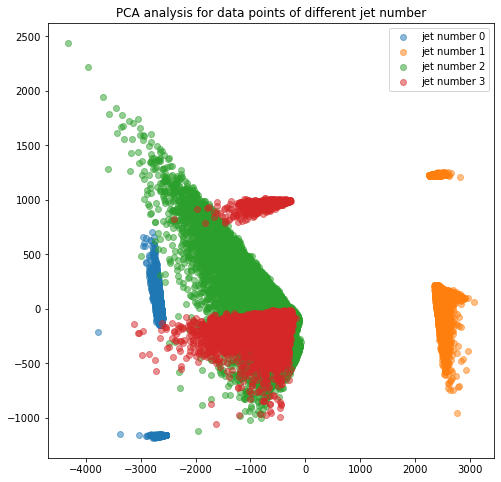

In [21]:
colors = ['r','g','b','y']
plt.rcParams["figure.figsize"] = (8,8)

for i,color in enumerate(colors):
    data_points = tX[tX[:,22] == i]
    data_points_PCA, basis = PCA(data_points, 2)
    plt.scatter(data_points_PCA[:,0], data_points_PCA[:,1], alpha = 0.5, label='jet number {}'.format(i))

plt.title('PCA analysis for data points of different jet number')
plt.legend()
plt.show()

We can see that the data points of different jet-num indeed follow a different distribution. This suggests that we can train 4 distinct models for the data belonging to each jet-num, but we think training 4 models instead of 1 will deviate from the original intention of this project.


However, we came up with an approach to distinctively treat data with each jet-num, which is expanding the features over their jet-num.  

The example of our proposed expanding works as follows:

(For simplicity, suppose the matrix has 5 features, the 3rd feature is the jet-num.)

<center>$ \left[ \begin{matrix}
   d_{0} \\ d_{1} \\ d_{2} \\ d_{3} \\ d_{4} 
  \end{matrix}  \right] = \left[ \begin{matrix}
   x_{00} & x_{10} & x_{20} & j_{0} & x_{40} \\
   x_{01} & x_{11} & x_{21} & j_{1} & x_{41} \\
   x_{02} & x_{12} & x_{22} & j_{2} & x_{42} \\
   x_{03} & x_{13} & x_{23} & j_{3} & x_{43} \\
   x_{04} & x_{14} & x_{24} & j_{0} & x_{44}
  \end{matrix}  \right]$

##### <center> expand over jet-num $\Downarrow$

    


$$
\left[
 \begin{matrix}
   x_{00} & x_{10} & x_{20} & j_{0} & x_{40} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0 & x_{01} & x_{11} & x_{21} & j_{1} & x_{41} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & x_{02} & x_{12} & x_{22} & j_{2} & x_{42} & 0 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & x_{03} & x_{13} & x_{23} & j_{3} & x_{43}\\
   x_{04} & x_{14} & x_{24} & j_{0} & x_{44} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
  \end{matrix} 
\right]
$$
    
From the expansion we can see that, the new features are expanded to be 4 times the length of the original feature, with only $\frac{1}{4}$ of them being non-zero. The original features are put into the expanded feature according to their jet-num. For the data with jet-num 0, they are put into the first quarter of the feature vectors, and for the data with jet-num 1, they are put into the second quarter of the feature vectors...
    
The purpose of this expansion is to seperately train a weight vector for the data with the same jet-num (using one model instead of 4). The data belonging to different jut-num will not interfere each other in the training process, because their feature vectors are orthogonal to each other. In practical, this feature expanding process allows us to train 4 seperate weight vectors using one model, it will look like this:

$$
\left[
 \begin{matrix}
   w_1 & w_2 & w_3 &w_4\\
  \end{matrix} 
\right]
$$
    
Each $w_i$ has the length 5, and is trained only by the data with the jet-num $i$.
    
In the testing process, we expand the test set using the same procedure, and in the predictions ($x w^T$), each data point will be multiplied with the weigh vector $w_i$ according to their jet-num.

<center>$ xw^T =\left[ \begin{matrix}
   d_{0}w_1^T \\ d_{1}w_2^T \\ d_{2}w_3^T \\ d_{3}w_4^T \\ d_{4}w_1^T \\
  \end{matrix}  \right]$

##### 1.2 Feature augmentation

For feature augmentation, the methods we are considering include the following:

- ***missing value indicator*** : Add the missing value indicators we defined in **1.1.1** to the features. 

- ***polynomial expansion***:   $\left[x_{1}, x_{2}\right., \left.x_{3}, \ldots\right] \rightarrow\left[x_{1}^{k}, x_{2}^{k}, x_{3}^{k}, \ldots\right]$


- ***2nd-degree cross product***:  $\left[x_{1}, x_{2}, x_{3}\right.,\ldots] \rightarrow\left[x_{1} x_{2}, x_{2} x_{3}, x_{1} x_{3}, \ldots\right]$


- ***3rd-degree cross product***: According to the correlation coefficient of each feature with the target y, we select the top 3 important features [$x_1$, $x_{11}$, $x_0$], and the feature ${\it PRI\_jet\_num}$ ($x_{22}$) . We add the 3rd-degree cross product of these four important features with other features [$x_2$, $x_3$, $x_4$, ...].

<center>$[x_0, x_1, x_2,]\rightarrow[x_1^2x_2, x_1x_2^2, x_1^2x_3, x_1x_3^2, ...]$

In [48]:
def fea_augmentation(x, method, poly_degree=None, neg_poly_degree=None, concatenate=True, print_info=False, standarize=True):
    x_aug = x.copy() if concatenate else []
    
    if 'polynomial' in method:
        for d in range(2, poly_degree + 1):
            try:
                x_aug = np.c_[x_aug, x ** d]
            except:
                x_aug = x**d
    
    if 'cross_product_degree_2' in method:
        for i in range(x.shape[1]):
            for j in range(i+1, x.shape[1]):
                x_aug = np.c_[x_aug, x[:, i]*x[:, j]]
            if print_info:
                print('\rAdding degree-two cross product features | {:.2%} complete'.format(float((i+1)/x.shape[1])), end='', flush=True)
        print('')
        
    if 'cross_product_degree_3' in method:
        for i in range(x.shape[1]):
            if i != 1:
                x_aug = np.c_[x_aug, x[:, 1]*(x[:, i]**2)]
                x_aug = np.c_[x_aug, (x[:, 1]**2)*x[:, i]]
                if (i != 11):
                    x_aug = np.c_[x_aug, x[:, 11]*(x[:, i]**2)]
                    x_aug = np.c_[x_aug, (x[:, 11]**2)*x[:, i]]
                    if (i != 13):
                        x_aug = np.c_[x_aug, x[:, 13]*(x[:, i]**2)]
                        x_aug = np.c_[x_aug, (x[:, 13]**2)*x[:, i]]
                        if (i != 22):
                            x_aug = np.c_[x_aug, x[:, 22]*(x[:, i]**2)]
                            x_aug = np.c_[x_aug, (x[:, 22]**2)*x[:, i]]
            if print_info:
                print('\rAdding degree-three cross product features | {:.2%} complete'.format(float((i+1)/x.shape[1])), end='', flush=True)
        print('')
    
    if 'missing_value_indicator' in method:
        x_aug = np.c_[x_aug, indicator_feature_1]
        x_aug = np.c_[x_aug, indicator_feature_2]
    
    if 'neg_polynomial' in method:
        for d in range(1, neg_poly_degree+1):
            try:
                x_aug = np.c_[x_aug, 1 / (x**d + 1e-4)]
            except:
                x_aug = 1 / (x**d + 1e-4)
    
    x_aug_mean = x_aug.mean(axis=0)
    x_aug_std = x_aug.std(axis=0)
    
    # re-standarize to avoid numerical problems for gradient descent
    if standarize == True:
        x_aug = (x_aug - x_aug.mean(axis=0)) / x_aug.std(axis=0)
    
    # add a constant column to the features
    if concatenate:
        x_aug = np.c_[np.ones((len(x_aug), 1)), x_aug]

    return x_aug, x_aug_mean, x_aug_std


- ***negative powers***:       $\left[x_1, x_2, \ldots\right]\rightarrow \left[ \frac{1}{(x_1^{k}+\delta)} , \frac{1}{(x_2^{k}+\delta)}, \ldots\right]$
- ***expand over jet_num***:   The expansion method we discussed in 1.1.5


First, we train the model on the standarized data (without any feature augmentation), and use this result as a baseline to quantify the improvements brought by feature augmentation.

* Test the accuracy without feature augmentation

In [22]:
x_std, _, _, _ = clean_standarize(tX, replace='median')

x_std_cst = np.c_[np.ones(len(x_std), ), x_std]
x_train, y_train, x_test, y_test = split_data(x_std_cst, y, 0.8, seed=1)
(train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
print('For original data, training accuracy for ridge is {}, test accuracy is {}\n'.format(train_acc_ridge, test_acc_ridge))

For original data, training accuracy for ridge is 0.744975, test accuracy is 0.74454



* Test the accuracy with: ***missing value indicator***

In [23]:
x_aug, _, _ = fea_augmentation(x_std, method = ['missing_value_indicator'])

x_train, y_train, x_test, y_test = split_data(x_aug, y, 0.8, seed=1)
(train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
print('Added missing value indicator, training accuracy for ridge is {}, test accuracy is {}\n'.format(train_acc_ridge, test_acc_ridge))

Added missing value indicator, training accuracy for ridge is 0.745015, test accuracy is 0.7457



* Test the accuracy with: ***missing value indicator*** and ***one-hot encoding***

In [25]:
x_aug, _, _ = fea_augmentation(x_std, method = ['missing_value_indicator'])
one_hot = one_hot_encoder(tX[:, 22])
x_std_onehot = np.c_[x_aug, one_hot]
x_std_onehot_cst = np.c_[np.ones(len(x_std_onehot), ), x_std_onehot]

x_train, y_train, x_test, y_test = split_data(x_std_onehot_cst, y, 0.8, seed=1)
(train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
print('After using one-hot encoding and missing value indicator, training accuracy is {}, test accuracy is {}\n'.format(train_acc_ridge, test_acc_ridge))

After using one-hot encoding and missing value indicator, training accuracy is 0.746665, test accuracy is 0.7472



We see that one-hot encoding provides very limited help (less than 0.2% improve), so in the following we will not use one-hot encodings.

* Test the accuracy with: ***polynomial expansion*** and ***missing value indicator***

In [27]:
polynomial_table = PrettyTable(['polynomial degree', 'train_accuracy', 'val_accuracy'])

for poly_degree in range(2, 13):
    x_aug, _, _ = fea_augmentation(x_std, method = ['polynomial', 'missing_value_indicator'], poly_degree=poly_degree)
    x_aug = expand_over_jetnum(x_aug)
    x_train, y_train, x_test, y_test = split_data(x_aug, y, 0.8, seed=1)
    (train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
    polynomial_table.add_row([poly_degree, "%.4f" % train_acc_ridge, "%.4f" % test_acc_ridge])
    print("\rAdded {}-degree polynomial expansion:, training accuracy is {:.4}, test accuracy is {:.4}".format(poly_degree, train_acc_ridge, test_acc_ridge), end='', flush=True)

print('\n')
print(polynomial_table)

Added 12-degree polynomial expansion:, training accuracy is 0.829, test accuracy is 0.82474

+-------------------+----------------+--------------+
| polynomial degree | train_accuracy | val_accuracy |
+-------------------+----------------+--------------+
|         2         |     0.7889     |    0.7876    |
|         3         |     0.8006     |    0.7999    |
|         4         |     0.8093     |    0.8076    |
|         5         |     0.8131     |    0.8116    |
|         6         |     0.8154     |    0.8134    |
|         7         |     0.8205     |    0.8174    |
|         8         |     0.8263     |    0.8232    |
|         9         |     0.8283     |    0.8248    |
|         10        |     0.8286     |    0.8246    |
|         11        |     0.8288     |    0.8244    |
|         12        |     0.8290     |    0.8247    |
+-------------------+----------------+--------------+


From the results, we can see that polynomial expansion provides best result when degree = 9. So we will keep the polynomial degree to be 9 while adding other augmentations below.

* Test the accuracy with: ***polynomial expansion***, ***missing value indicator*** and ***2nd-degree cross product***

In [29]:
x_aug, _, _ = fea_augmentation(x_std, method = ['polynomial', 'missing_value_indicator', 'cross_product_degree_2'], poly_degree=9, print_info=True)
x_aug = expand_over_jetnum(x_aug)
x_train, y_train, x_test, y_test = split_data(x_aug, y, 0.8, seed=1)
(train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')

print('\n')
print('Added 9th degree polynomial expansion, missing value indicator and 2nd-degree cross product:\ntraining accuracy is {}, test accuracy is {}\n'.format(train_acc_ridge, test_acc_ridge))

Adding degree-two cross product features | 100.00% complete


Added 9th degree polynomial expansion, missing value indicator and 2nd-degree cross product:
training accuracy is 0.834325, test accuracy is 0.82856



* Test the accuracy with: ***polynomial expansion***, ***missing value indicator***, ***2nd-degree and 3-rd degree cross product***

In [30]:
jet_num = tX[:, 22]

x_aug, _, _ = fea_augmentation(x_std, method = ['polynomial', 'missing_value_indicator', 'cross_product_degree_2', 'cross_product_degree_3'], poly_degree=9, print_info=True)
x_aug = expand_over_jetnum(x_aug)
x_train, y_train, x_test, y_test = split_data(x_aug, y, 0.8, seed=1)
(train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
print('Added 9th degree polynomial expansion, missing value indicator, 2nd-degree and 3rd-degree cross product:\ntraining accuracy is {}, test accuracy is {}\n'.format(train_acc_ridge, test_acc_ridge))

Adding degree-two cross product features | 100.00% complete
Adding degree-three cross product features | 100.00% complete
Added 9th degree polynomial expansion, missing value indicator, 2nd-degree and 3rd-degree cross product:
training accuracy is 0.836985, test accuracy is 0.83104



* Test the accuracy with: ***polynomial expansion***, ***missing value indicator***, ***2nd-degree and 3-rd degree cross product*** and ***negative powers***

In [31]:
# to avoid running the same process many times: 
# define an intermediate x_aug_temp, which is the feature augmentation result using 'polynomial', 'missing_value_indicator', 'cross_product_degree_2', 'cross_product_degree_3'.
# get the final x_aug by doing feature augmentation through negative powers original and then concatenating with x_aug_temp
x_aug_temp, _, _  = fea_augmentation(x_std, method = ['polynomial', 'missing_value_indicator', 'cross_product_degree_2', 'cross_product_degree_3'], poly_degree=9, print_info=True, concatenate=True)

neg_power_table = PrettyTable(['negative power degree', 'train_accuracy', 'val_accuracy'])

for neg_pol_degree in range(1, 10):
    gc.collect()
    x_aug_negpol, _, _ = fea_augmentation(x_std, method = ['neg_polynomial'], neg_poly_degree=neg_pol_degree, concatenate=False)
    x_aug = np.c_[x_aug_temp, x_aug_negpol]
    x_train, y_train, x_test, y_test = split_data(x_aug, y, 0.8, seed=1)
    (train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
    neg_power_table.add_row([-neg_pol_degree, "%.4f" % train_acc_ridge, "%.4f" % test_acc_ridge])
    print('\rAdded {}-degree negative power: training accuracy for ridge is {:.4}, test accuracy is {:.4}'.format(neg_pol_degree, train_acc_ridge, test_acc_ridge), end='', flush=True)

print('\n')
print(neg_power_table)

Adding degree-two cross product features | 100.00% complete
Adding degree-three cross product features | 100.00% complete
Added 9-degree negative power: training accuracy for ridge is 0.8345, test accuracy is 0.8318

+-----------------------+----------------+--------------+
| negative power degree | train_accuracy | val_accuracy |
+-----------------------+----------------+--------------+
|           -1          |     0.8312     |    0.8284    |
|           -2          |     0.8326     |    0.8287    |
|           -3          |     0.8335     |    0.8299    |
|           -4          |     0.8337     |    0.8304    |
|           -5          |     0.8341     |    0.8305    |
|           -6          |     0.8341     |    0.8306    |
|           -7          |     0.8343     |    0.8308    |
|           -8          |     0.8343     |    0.8310    |
|           -9          |     0.8345     |    0.8310    |
+-----------------------+----------------+--------------+


From the results, we can see that with negative power degree being -8, we have the best validation accuracy. The best accuracy we have is 0.831.

* Test the accuracy with: ***polynomial expansion***, ***missing value indicator***, ***2nd-degree and 3-rd degree cross product***, ***negative powers*** and ***expand over jetnum***

In [38]:
x_aug_negpol, _, _ = fea_augmentation(x_std, method = ['neg_polynomial'], neg_poly_degree=8, concatenate=False)
x_aug = np.c_[x_aug_temp, x_aug_negpol]
x_aug = expand_over_jetnum(x_aug)
x_train, y_train, x_test, y_test = split_data(x_aug, y, 0.8, seed=1)
(train_acc_ridge, test_acc_ridge) = train_and_test(((x_train, y_train), (x_test, y_test)), 'ridge')
print('\rAdded expansion over jetnum: training accuracy for ridge is {:.4}, test accuracy is {:.4}'.format(train_acc_ridge, test_acc_ridge), end='', flush=True)

print('\n')

Added expansion over jetnum: training accuracy for ridge is 0.8397, test accuracy is 0.8334



#### Step II: Cross Validation

In Step I, we have identified important features, and the effects of feature engineering.  
In Step II, we are going to cross-validate the super-parameters of each model using 5-fold cross-validation. Besides, we also cross-validate the polynomial expansion degree and negative power degree for each model respectively, as in Step I we only identified the optimal degrees for least square, and the optimal degrees for other models can be different. 

So overall, the parameters that are going to be cross-validated for each model are:
* least_squares_GD: ***po_degree***, ***ne_degree***

* least_squares_SGD: ***po_degree***, ***ne_degree***

* least_squares: ***po_degree***, ***ne_degree***

* ridge: ***$\lambda$***, ***po_degree***, ***ne_degree***

* logistic_regression: ***po_degree***, ***ne_degree***

* reg_logistic_regression: ***$\lambda$***, ***po_degree***, ***ne_degree***

here ***po_degree*** stands for polynomial expansion degree, ***ne_degree*** stands for negative power degree. 

However, theoretically least_squares_GD and least_squares_SGD are going to converge to the same point as least_squares, so there is no need to do cross-validation on GD and SGD versions of least_squares.  
Besides, the GD version and SGD version of logistic regression are also theoretically converging to the same point, so we will only do cross-validation on the SGD version of logistic_regression and reg_logistic_regression.  

Therefore, we will conduct cross-validation on only the following models:  
* least_squares: ***po_degree***, ***ne_degree***

* ridge: ***$\lambda$***, ***po_degree***, ***ne_degree***

* logistic_regression(SGD): ***po_degree***, ***ne_degree***

* reg_logistic_regression(SGD): ***$\lambda$***, ***po_degree***, ***ne_degree***

In [9]:
from implementations import *

# to avoid running the same process many times: 
# first, we generate x_aug_temp using feauture augmentation methods except polynomial expansion and negative powers, 
# when doing cross validation x_aug_temp is concatenated to feautures generated by polynomial expansion and negative powers
x_aug_temp, _, _ = fea_augmentation(x_std, method = ['missing_value_indicator', 'cross_product_degree_2', 'cross_product_degree_3'], print_info=True, concatenate=True)

Adding degree-two cross product features | 100.00% complete
Adding degree-three cross product features | 100.00% complete


In [11]:
from implementations import *

y = y.reshape(len(y), 1)


ls_params_grid = {'po_degree': [5, 8, 10], 'ne_degree': [5, 8]}
least_squares_CV(x_std, y, x_aug_temp, params_grid = ls_params_grid)

ridge_params_grid = {'lambd': [1e-3, 1e-4, 1e-5], 'po_degree': [5, 8, 10], 'ne_degree': [5, 8]}
ridge_regression_CV(x_std, y, x_aug_temp, params_grid = ridge_params_grid)

Cross validation starts for least_squares
for po_degree : 10, 'ne_degree': 8, val_accuracy = 0.8283 | 100.00% completed
Least_Squares cross validation result:
+-----------+-----------+--------------+
| po_degree | ne_degree | val_accuracy |
+-----------+-----------+--------------+
|     5     |     5     |    0.8314    |
|     5     |     8     |    0.8310    |
|     8     |     5     |    0.8315    |
|     8     |     8     |    0.8234    |
|     10    |     5     |    0.8330    |
|     10    |     8     |    0.8283    |
+-----------+-----------+--------------+
The optimal params for least squares are, po_degree: 10, ne_degree: 5, with val_accuracy: 0.8329920000000002

Cross validation starts for ridge_regression
for lambda: 1e-05, po_degree : 10, ne_degree: 8, val_accuracy = 0.8325 | 100.00% completed
Ridge_regression cross validation result:
+--------+-----------+-----------+--------------+
| lambda | po_degree | ne_degree | val_accuracy |
+--------+-----------+-----------+---------

(1e-05, 10, 8)

In [ ]:
from implementations import *

log_regression_params_grid = {'lr': [1e-4], 'po_degree': [5, 8, 10], 'ne_degree': [5, 8]}
logistic_regression_CV(x_std, y.reshape(len(y),), x_aug_temp, params_grid=log_regression_params_grid, max_iters = 3000, mode = 'SGD', reg = False)

In [ ]:
reg_log_regression_params_grid = {'lambd': [1e-3, 1e-4, 1e-5], 'lr': [1e-4], 'po_degree': [5, 8, 10], 'ne_degree': [5, 8]}
logistic_regression_CV(x_std, y.reshape(len(y),), x_aug_temp, params_grid=reg_log_regression_params_grid, max_iters = 3000, mode = 'SGD', reg = True)

#### Step III: Choose Best Model

After feature engineering and cross validation, we are going to choose our optimal model.  
All models have very close results. Here we choose ridge as our optimal model, for it has less risk of overfitting and is very fast to train.  
In this step, we are going to train the optimal model on the entire training set. Using this model, we will test on the test set and submit our results.

Replace missing value, standarize, and include augmented feautures:

In [39]:
x_std, train_means, train_std, train_median = clean_standarize(tX, replace='median')
x_aug, x_aug_train_mean, x_aug_train_std = fea_augmentation(x_std, method = ['polynomial', 'neg_polynomial', 'missing_value_indicator', 'cross_product_degree_2', 'cross_product_degree_3'], poly_degree=10,  neg_poly_degree=8, print_info=True, concatenate=True)

Adding degree-two cross product features | 100.00% complete
Adding degree-three cross product features | 100.00% complete


In [40]:
jet_num = tX[:, 22]

In [41]:
x_aug_expand = expand_over_jetnum(x_aug)

Train the model, and report training accuracy:

In [42]:
w_ridge, _ = ridge_regression(y, x_aug_expand, 0.0001)
print('Training accuracy on the optimal model: {}'.format(compute_accuracy(y, x_aug_expand, w_ridge, method='linear')))

Training accuracy on the optimal model: 0.838768


## Generate predictions and save ouput in csv format for submission:

In [43]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

Generate the missing value indicator features for the test set:

In [44]:
indicator_feature_1 = np.int32(tX_test[:,0] == -999)
indicator_feature_2 =  np.int32(tX_test[:,23] == -999) + np.int32(tX_test[:,24] == -999) + np.int32(tX_test[:,25] == -999)

jet_num = tX_test[0:, 22]

Replace the missing values of test set with medians of training set, then standarize the test set using mean and std of training set:   
Do feature augmentation in the same way as training set:

In [ ]:
print('Standarizing and doing feature augmentation for test set\n')
x_test_std, _, _, _ = clean_standarize(tX_test, replace='median', mode='test_set', fea_means=train_means, fea_std=train_std, fea_replace=train_median)
x_test_aug, _, _ = fea_augmentation(x_test_std, method = ['polynomial', 'neg_polynomial', 'missing_value_indicator', 'cross_product_degree_2', 'cross_product_degree_3'], poly_degree=10,  neg_poly_degree=8, print_info=True, concatenate=True, standarize=False)

In [ ]:
# re-standarize test set
x_test_aug = x_test_aug[:, 1:]
x_test_aug = (x_test_aug - x_aug_train_mean) / x_aug_train_std
x_test_aug = np.c_[np.ones((len(x_test_aug), 1)), x_test_aug]

In [ ]:
# expand over jetnumber
x_test_aug_expand = expand_over_jetnum(x_test_aug)

In [ ]:
# make prediction
# predict_labels(x_test_aug_expand, w_ridge, method='linear')

In [ ]:
OUTPUT_PATH = 'y_pred.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(x_test_aug, w_ridge, method='linear')
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

Make predictions and save as csv file: